In [1]:
import torch
from trl import SFTTrainer
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

## Dataset

In [3]:
train_dataset = load_dataset("mosaicml/dolly_hhrlhf", split="train")
print(train_dataset)

Dataset({
    features: ['prompt', 'response'],
    num_rows: 59310
})


Create a new text column for training.

In [4]:
new_column = []
for i in range(len(train_dataset["response"])):
    new_column.append(train_dataset[i]["prompt"]+train_dataset[i]["response"])
train_dataset = train_dataset.add_column("text",new_column)

# check if the entries in "text" column is correct!
print(train_dataset)
print("\n"*2)
print(train_dataset[1]["prompt"] + train_dataset[1]["response"])
print("\n"*2)
print(train_dataset[1]["text"])

Dataset({
    features: ['prompt', 'response', 'text'],
    num_rows: 59310
})



Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
what is Kubernetes?

### Response:
Kubernetes is an open-source container orchestration system for automating software deployment, scaling, and management. Originally designed by Google, the project is now maintained by the Cloud Native Computing Foundation.



Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
what is Kubernetes?

### Response:
Kubernetes is an open-source container orchestration system for automating software deployment, scaling, and management. Originally designed by Google, the project is now maintained by the Cloud Native Computing Foundation.


## Estimate the appropriate max_token_length value

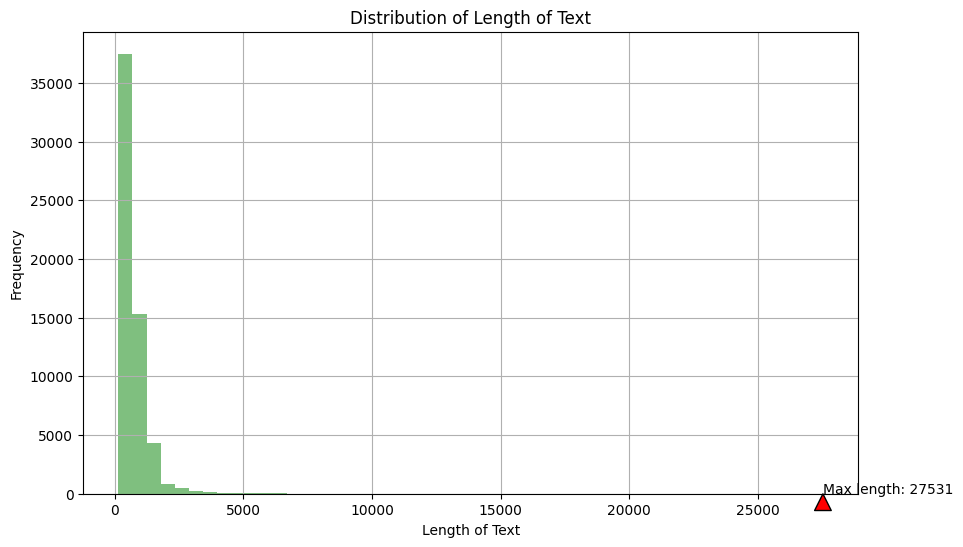

In [5]:
pandas_format = train_dataset.to_pandas()

pandas_format['text_length'] = pandas_format['text'].apply(len)

max_length = pandas_format['text_length'].max()

plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')

plt.annotate('Max length: {}'.format(max_length), xy=(max_length, 0), xytext=(max_length, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
max_num = 2048
mask = pandas_format['text_length'] > max_num
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100

print("The percentage of text documents with a length greater than {} is: {}%".format(max_num,percentage))

The percentage of text documents with a length greater than 2048 is: 2.733097285449334%


## Model

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", load_in_8bit=True, device_map="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

In [8]:
model_training_args = TrainingArguments(
        output_dir="phi2_instruct/",
        per_device_train_batch_size=4,
        optim="adamw_torch",
        logging_steps=100,
        learning_rate=5e-5,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
        num_train_epochs=3,
        save_strategy="epoch"
    )

lora_peft_config = LoraConfig(
    r=16, 
    lora_alpha=32, 
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj","k_proj"],
    task_type="CAUSAL_LM")

SFT_trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        dataset_text_field="text",
        max_seq_length=2048,
        tokenizer=tokenizer,
        args=model_training_args,
        packing=True,
        peft_config=lora_peft_config,
    )

## Training

In [9]:
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))
model = prepare_model_for_int8_training(model)
model = get_peft_model(model, lora_peft_config)

/home/localstorage/miniconda3/envs/blip/lib/python3.10/site-packages/peft/utils/other.py:141: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [10]:
print(model)
print("\n\nTotal params = ",sum(p.numel() for p in model.parameters()))
print("Trainable params = ",sum(p.numel() for p in model.parameters() if p.requires_grad))

print("\n v_proj params")
for p in model.base_model.model.model.layers[0].self_attn.v_proj.parameters():
    print(p.shape,p.dtype,p.requires_grad)

print("\n q_proj LoRA params")
for p in model.base_model.model.model.layers[0].self_attn.q_proj.lora_A.parameters():
    print(p.shape,p.dtype,p.requires_grad)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(50295, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Lin

In [11]:
training_args = model_training_args
trainer = SFT_trainer
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/localstorage/miniconda3/envs/blip/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
80,1.850900
160,1.705600
240,1.614500
320,1.603400
